In [280]:
import numpy as np
import os
import random
import pickle as pk
from interval import interval
import scipy.optimize
import librosa
import matplotlib.pyplot as plt
%matplotlib inline

In [409]:
def compute_q(pi, d_arr):
    return pi.dot(1/(1 + d_arr)) - 1

def compute_s(pi, d_arr):
    return pi.dot(1/((1 + d_arr)**2)) - 1

def compute_est_npc(lamb, pi, d_arr):
    return np.exp(lamb * compute_q(pi, d_arr))

def compute_st_npc_sq(lamb, pi, d_arr):
    return np.exp(lamb * compute_s(pi, d_arr))

def fc(x, *args):
    pc, d_arr = args
    lamb = max(x[0], 0)
    pi = np.maximum(x[1:], 0)
    pi /= pi.sum()
    d_arr = np.array(d_arr)
    assert d_arr.shape == pi.shape
    
    est_npc = compute_est_npc(lamb, pi, d_arr)
    est_npc_sq = compute_st_npc_sq(lamb, pi, d_arr)
    cnst = pc**2 - 2*pc + 1
    
    val = cnst + 2*(pc - 1) * est_npc + est_npc_sq
    return val


def grad_fc(x, *args):
    pc, d_arr = args
    lamb = max(x[0], 0)
    pi = np.maximum(x[1:], 0)
    pi /= pi.sum()
    d_arr = np.array(d_arr)
    
    q = compute_q(pi, d_arr)
    s = compute_s(pi, d_arr)
    est_npc = compute_est_npc(lamb, pi, d_arr)
    est_npc_sq = compute_st_npc_sq(lamb, pi, d_arr)
    
    grad = np.zeros_like(x)
    grad[0] = 2 * (pc - 1) * q * est_npc + s * est_npc_sq
    for idx, d in enumerate(d_arr):
        grad[idx+1] = 2 * (pc - 1) * (lamb / (1 + d)) * est_npc + (lamb / ((1 + d)**2)) * est_npc_sq
    
    return grad


def hess_fc(x, *args):
    pc, d_arr = args
    lamb = max(x[0], 0)
    pi = np.maximum(x[1:], 0)
    pi /= pi.sum()
    d_arr = np.array(d_arr)
    
    q = compute_q(pi, d_arr)
    s = compute_s(pi, d_arr)
    est_npc = compute_est_npc(lamb, pi, d_arr)
    est_npc_sq = compute_st_npc_sq(lamb, pi, d_arr)
    
    hess = np.zeros((x.shape[0], x.shape[0]))
    
    hess[0, 0] = 2 * (pc - 1) * (q**2) * est_npc + (s**2) * est_npc_sq
    for idx1, d1 in enumerate(d_arr):
        t1 = 2 * ((pc - 1)/(1 + d1)) * est_npc * (1 + lamb * est_npc)
        t2 = (1 / ((1 + d1)**2)) * est_npc_sq * (1 + lamb * est_npc_sq)
        val = t1 + t2
        
        hess[0, idx1+1] = val
        hess[idx1+1, 0] = val
        
        for idx2, d2 in enumerate(d_arr):
            if idx2 < idx1:
                continue
            t1 = 2 * (pc - 1) * lamb**2/((1 + d1)*(1 + d2)) * est_npc
            t2 = lamb**2/(((1 + d1)**2)*((1 + d2)**2)) * est_npc_sq
            val = t1 + t2
            hess[idx1+1, idx2+1] = val
            hess[idx2+1, idx1+1] = val
        
    return hess

In [166]:
soundscape_duration = 10.0

In [410]:
def get_class_parameters(class_dir, pc, soundscape_duration):
    d_arr = []
    for fname in os.listdir(class_dir):
        clip_path = os.path.join(class_dir, fname)
        clip_duration = librosa.get_duration(filename=clip_path)
        d_arr.append(clip_duration / soundscape_duration)

    # Only consider unique durations
    d_arr = np.unique(np.array(d_arr))
    
    Nc = d_arr.shape[0]
    
    A = np.vstack((
        np.eye(Nc+1),
        np.concatenate((np.array([0,]), np.ones(Nc))),
        np.concatenate((np.array([0,]), -np.ones(Nc))),
    )).astype(np.float32)

    ub = (np.ones((Nc+3,)) * float('inf')).astype(np.float32)
    lb = np.concatenate((np.zeros((Nc+1)), [1, -1])).astype(np.float32)
    
    constraints = scipy.optimize.LinearConstraint(A, lb, ub, keep_feasible=True)
    lamb_0 = 5.0
    x0 = np.concatenate(([lamb_0], np.ones((Nc,))/Nc)).astype(np.float32)
    
    # Ensure that elements of pi sum to 1 w.r.t. machine precision
    x0[1] += (1 - np.dot(x0[1:], np.ones((Nc,))))
    res = scipy.optimize.minimize(fc,
                            x0,
                            args=(pc, d_arr),
                            jac=grad_fc,
                            hess=hess_fc,
                            constraints=constraints)
    lamb_c = res.x[0]
    pi_c = res.x[1:]
    
    return (lamb_c, pi_c, d_arr), res.fun

In [188]:
sensor_pred_path = 'sensor_predictions.pkl'
dataset_dir = './us8k-foreground-ust/train'

with open(sensor_pred_path, 'rb') as f:
    sensor_pred = pk.load(f)

KeyboardInterrupt: 

In [190]:
labels = [
    "engine",
    "machinery-impact",
    "alert-signal",
    "music",
    "human-voice",
    "dog",
]

In [397]:
sensor_id = "b827eb252949"

In [378]:
hour_blocks = ["21-3", "3-9", "9-15", "15-21"]

In [412]:
raw_params_dict = {}
bin_params_dict = {}

for sensor_id, sensor_dict in sensor_pred.items():
    raw_pred_dict = {x: [] for x in hour_blocks}
    bin_pred_dict = {x: [] for x in hour_blocks}
    
    for time_tuple, pred_dict in sensor_dict.items():
        hour_block = time_tuple[-1]
        raw_pred_dict[hour_block].append(pred_dict['raw'])
        bin_pred_dict[hour_block].append(pred_dict['bin'])
        
        
    for hour_block in hour_blocks:
        if len(raw_pred_dict[hour_block]) == 0:
            continue
        raw_p_list = np.concatenate(raw_pred_dict[hour_block]).mean(axis=0)
        bin_p_list = np.concatenate(bin_pred_dict[hour_block]).mean(axis=0)
        
        for class_name in os.listdir(dataset_dir):
            name = "_".join([class_name, sensor_id, hour_block])
            class_dir = os.path.join(dataset_dir, class_name)
            cls_idx = labels.index(class_name)

            raw_pc = raw_p_list[cls_idx]
            bin_pc = bin_p_list[cls_idx]
            (lamb_c_raw, pi_c_raw, d_arr), obj_raw = get_class_parameters(class_dir, raw_pc, soundscape_duration)
            (lamb_c_bin, pi_c_bin, _), obj_bin = get_class_parameters(class_dir, bin_pc, soundscape_duration)

            raw_params_dict[name] = {
                'class': class_name,
                'lamb_c': lamb_c_raw,
                'pi_c': pi_c_raw,
                'obj': obj_raw,
                'durations': d_arr,
                'pc': raw_pc
            }
            bin_params_dict[name] = {
                'class': class_name,
                'lamb_c': lamb_c_bin,
                'pi_c': pi_c_bin,
                'obj': obj_bin,
                'durations': d_arr,
                'pc': bin_pc
            }



In [381]:
raw_params_path = 'raw_params.pkl'
bin_params_path = 'bin_params.pkl'
with open(raw_params_path, 'wb') as f:
    pk.dump(raw_params_dict, f)
with open(bin_params_path, 'wb') as f:
    pk.dump(bin_params_dict, f)

In [423]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

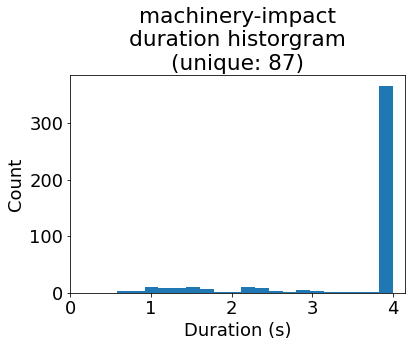

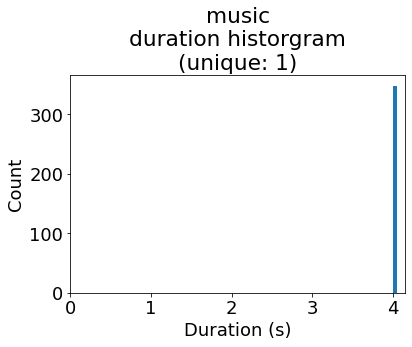

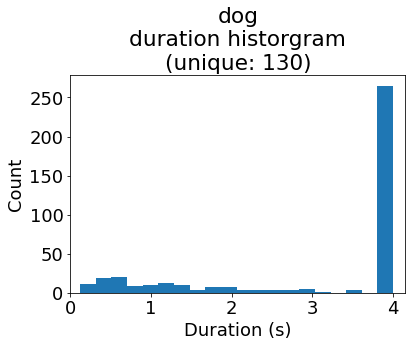

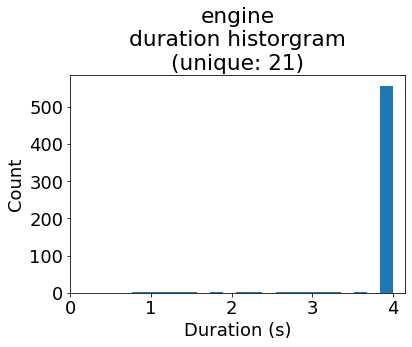

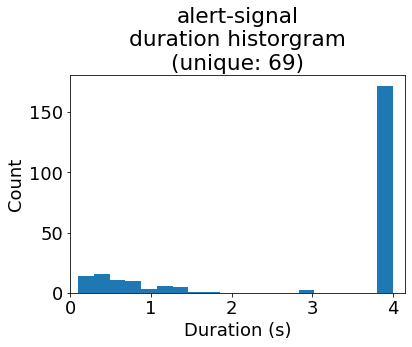

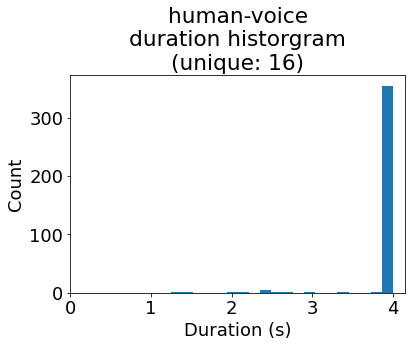

In [426]:
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    d_arr = []
    for fname in os.listdir(class_dir):
        clip_path = os.path.join(class_dir, fname)
        clip_duration = librosa.get_duration(filename=clip_path)
        d_arr.append(clip_duration)
        
    num_unique = np.unique(d_arr).shape[0]

    fig = plt.figure()
    plt.hist(d_arr, bins=20)
    plt.title(class_name + "\nduration historgram\n(unique: {})".format(num_unique))
    plt.xlabel('Duration (s)')
    plt.ylabel('Count')
    plt.xlim([0, 4.15])


In [440]:
obj_list = []
class_obj_list = {x: [] for x in labels}

for params_name, params_dict in raw_params_dict.items():
    lamb_c = max(params_dict['lamb_c'], 0.0)
    pi_c = np.maximum(params_dict['pi_c'], 0)
    pi_c = pi_c / pi_c.sum()
    obj = params_dict['obj']
    durations = params_dict["durations"] * soundscape_duration
    
    
    d_arr = params_dict["durations"]
    class_name = params_name.split('_')[0]
    cls_idx = labels.index(class_name)

    pc = params_dict["pc"]
    pc_est = 1 - compute_est_npc(lamb_c, pi_c, d_arr)
    obj = np.abs(pc - pc_est)**2
    obj_list.append(obj)
    
    class_obj_list[params_name.split('_')[0]].append(obj)

In [445]:
print("Overall: {} +/- {}".format(np.mean(obj_list), np.std(obj_list)))
for label, objlist in class_obj_list.items():
    print("{}: {} +/- {}".format(label, np.mean(objlist), np.std(objlist)))


Overall: 0.0004952039901258013 +/- 0.0008923369937788718
engine: 0.000174603269639347 +/- 0.0001900508904501252
machinery-impact: 0.00021736859264860078 +/- 8.883557277832939e-05
alert-signal: 7.777442362050428e-05 +/- 6.255466404637659e-05
music: 3.4132615786296884e-05 +/- 6.1487699805943565e-06
human-voice: 0.0024226394807255244 +/- 0.0004875878223271372
dog: 4.47055583345351e-05 +/- 8.438004641232411e-05


In [ ]:
results_dir = './results_plots'
os.makedirs(results_dir, exist_ok=True)

for params_name, params_dict in raw_params_dict.items():
    if "b827eb252949_9-15" not in params_name:
        continue
    
    lamb_c = max(params_dict['lamb_c'], 0.0)
    pi_c = np.maximum(params_dict['pi_c'], 0)
    pi_c = pi_c / pi_c.sum()
    obj = params_dict['obj']
    durations = params_dict["durations"] * soundscape_duration
    
    d_arr = params_dict["durations"]
    class_name = params_name.split('_')[0]
    cls_idx = labels.index(class_name)

    pc = params_dict["pc"]
    pc_est = 1 - compute_est_npc(lamb_c, pi_c, d_arr)
    
    fig = plt.figure(figsize=(9,7))
    ax = plt.gca()
    ax.scatter(durations, pi_c)
    ax.set_title("Fitted parameters: {}\n$\lambda_c$ = {}\n$p_c$ = {}\n$\hat p_c$ = {}\n".format(params_name, lamb_c, pc, pc_est))
    ax.set_ylabel("Clip probabilities")
    ax.set_xlabel("Clip duration")
    ax.set_xlim(xmin=0, xmax=4)
    ax.set_ylim(ymin=0, ymax=1)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, params_name + ".png"))
    plt.close()

In [458]:
results_dir = './results_plots'
os.makedirs(results_dir, exist_ok=True)

figs_per_img = 15
ncols = 3
nrows = figs_per_img // ncols

for idx, (params_name, params_dict) in enumerate(raw_params_dict.items()):
    subplot_idx = idx % figs_per_img
    if subplot_idx == 0:
        if idx > 0:
            plt.savefig(os.path.join(results_dir, 'results_{}.png'.format((idx - 1) // figs_per_img)))
            plt.close()
        fig, axes = plt.subplots(nrows=nrows, ncols=3,
                           figsize=(9*ncols, 7*nrows))
        
    col_idx = subplot_idx % ncols
    row_idx = subplot_idx // ncols
    ax = axes[row_idx, col_idx]
    
    lamb_c = max(params_dict['lamb_c'], 0.0)
    pi_c = np.maximum(params_dict['pi_c'], 0)
    pi_c = pi_c / pi_c.sum()
    obj = params_dict['obj']
    durations = params_dict["durations"] * soundscape_duration
    
    d_arr = params_dict["durations"]
    class_name = params_name.split('_')[0]
    cls_idx = labels.index(class_name)

    pc = params_dict["pc"]
    pc_est = 1 - compute_est_npc(lamb_c, pi_c, d_arr)
    
    ax.scatter(durations, pi_c)
    ax.set_title("Fitted parameters: {}\n$\lambda_c$ = {}\n$p_c$ = {}\n$\hat p_c$ = {}\n".format(params_name, lamb_c, pc, pc_est))
    ax.set_ylabel("Clip probabilities")
    ax.set_xlabel("Clip duration")
    ax.set_xlim(xmin=0, xmax=4)
    ax.set_ylim(ymin=0, ymax=1)
    plt.tight_layout()

idx += 1
plt.savefig(os.path.join(results_dir, 'results_{}.png'.format((idx - 1) // figs_per_img)))
plt.close()

In [3]:
def compute_coverage(x, seg_len=1):
    line_seg = interval[0, seg_len]
    x = line_seg & x 
    total_len = 0.0 
    for comp in x.components: 
        start = comp.extrema[0][0] 
        end = comp.extrema[1][0] 
        total_len += end - start 
    return total_len / seg_len 


In [26]:
def simulate(lamb_c, pi_c, d_arr, n_trials):
    trials = []
    for _ in range(n_trials):
        n_intervals = np.random.poisson(lamb_c)
        union_int = interval()
        int_len = np.random.choice(d_arr, p=pi_c)
        for _ in range(n_intervals):
            t0 = np.random.uniform(-int_len, 1.0)
            t1 = t0 + int_len
            curr_int = interval[t0, t1]
            if union_int is None:
                union_int = curr_int
            else:
                union_int = union_int | curr_int
        cov = compute_coverage(union_int)
        trials.append(cov)
    return np.mean(trials)

In [27]:
# p_exp_comp = np.exp(lamb * (1/(1+int_len) - 1))
# p_exp = 1 - p_exp_comp
# p_emp = trials.mean()
# p2_exp = np.exp(lamb * (1/(1+int_len)**2 - 1)) - 2 * p_exp_comp + 1
# p2_emp = (trials**2).mean()
# print("p expected: {}".format(p_exp))
# print("p emperical: {}".format(p_emp))
# print("p^2 expected: {}".format(p2_exp))
# print("p^2 emperical: {}".format(p2_emp))

p expected: 0.048299553263549955
p emperical: 0.0482942282561117
p^2 expected: 0.0027768992660009983
p^2 emperical: 0.0027862276479216235


In [ ]:
n_trials = 20000
sim_results = {}
for params_name, params_dict in raw_params_dict.items():
    lamb_c = params_dict['lamb_c']
    pi_c = params_dict['pi_c']
    d_arr = params_dict["durations"]
    class_name, sensor_id, month, dayofweek, hourblock = params_name.split('_')
    time_tuple = (int(month), dayofweek, hourblock)
    cls_idx = labels.index(class_name)

    pc = sensor_pred[sensor_id][time_tuple]['raw'].sum(axis=0)[cls_idx]
    emp_pc = simulate(lamb_c, pi_c, d_arr, n_trials)
    
    sim_results[params_name] = {
        'pc': pc,
        'emb_pc' : emp_pc,
        'error': (pc - emp_pc)**2
    }